# 1. CPU Cache
---

The CPU cache stores frequently used **data and instructions from the main memory**, as accessing data from the CPU cache is much faster than accessing data from the main memory. In a multi-core CPU, each core has its own cache memory. It is possible to have many copies of shared data: one copy in the **main memory** and one in the local cache of each processor that requested it. When one of the copies of data is changed, the other copies must reflect that change. 

The **Cache Coherence** problem is the challenge of keeping multiple local caches synchronized when one of the processors updates its local copy of data which is shared among multiple caches.

# 2. 并发引起的问题
---

首先，我们要知道并发要解决的是什么问题？并发要解决的是单进程情况下硬件资源无法充分利用的问题。而造成这一问题的主要原因是CPU-内存-磁盘三者之间速度差异实在太大。如果将CPU的速度比作火箭的速度，那么内存的速度就像火车，而最惨的磁盘，基本上就相当于人双腿走路。这样造成的一个问题，就是CPU快速执行完它的任务的时候，很长时间都会在等待磁盘或是内存的读写。

计算机的发展有一部分就是如何重复利用资源，解决硬件资源之间效率的不平衡, 并引入了新的概念:

- CPU增加缓存机制，平衡与内存的速度差异
- 引入并发概念, 增加线程切换, 程序计数器, 时间片等多个概念
- 编译器的指令优化 (compiler reordering vs memory reordering)

## 2.1. 资源高效利用带来的新问题

- **增加缓存带来的可见性问题(Visibility)**

Visibility is about one aspect: whether the changes (or effects) made by one thread to a shared variable will be visible to other threads or not?

现在基本都是多核CPU，各个线程可能运行在不同CPU核上面，每个CPU核各有各自的CPU缓存。CPU对变量的修改通常都会先写入CPU缓存，再写回内存。这就会出现这样一种情况，线程1修改了变量A，但此时修改后的变量A只存储在CPU缓存中。这时候线程B去内存中读取变量A，依旧只读取到旧的值，这就是可见性问题。

- **线程切换带来的原子性问题(Atomicity)**

为了更充分得利用CPU，引入了CPU时间片时间片的概念。比如在进行读写磁盘等耗时高的任务时，就可以将宝贵的CPU资源让出来让其他线程去获取CPU并执行任务。

A **time slice** is a period of time that a thread is allowed to use a core of the CPU.

这样的切换也会导致问题，那就是会破坏线程某些任务的原子性。

比如count += 1, 映射到CPU指令有三条，读取count变量指令，变量加1指令，变量写回指令。虽然在高级语言（java）看来它就是一条指令，但对CPU来说是三个指令，并且这三条指令的原子性无法保证。也就是说，可能在执行到任意一条指令的时候被打断，CPU被其他线程抢占了。而这个期间变量值可能会被修改，这里就会引发数据不一致的情况了。在高并发场景下，很多时候都会通过锁实现原子性。

- **编译器优化带来的有序性问题(Ordering)**

```java
public class Singleton {
 
 private Singleton() {}

 private static Singleton sInstance;

 public static Singleton getInstance() {

    if (sInstance == null) {	//第一次验证是否为null
      synchronized (Singleton.class) {   //加锁
        if (sInstance == null) {	  //第二次验证是否为null
          sInstance = new Singleton();  //创建对象
                 }
             }
         }
    return sInstance;
    }

}
```

即通过两段判断加锁来保证单例的成功生成，但在极小的概率下，可能会出现异常情况。原因就出现在`sInstance = new Singleton()`这一行代码上。这行代码，我们理解的执行顺序应该是这样:

1. 为Singleton象分配一个内存空间。
2. 在分配的内存空间实例化对象。
3. 把Instance 引用地址指向内存空间。

但在实际编译的过程中，编译器有可能会帮我们进行优化，优化完它的顺序可能变成如下:

1. 为Singleton对象分配一个内存空间。
2. 把instance 引用地址指向内存空间。
3. 在分配的内存空间实例化对象。

按照优化完的顺序，当并发访问的时候，可能会出现这样的情况:

1. A线程进入方法进行第1次instance == null判断。
2. 此时A线程发现instance 为null 所以对Singleton.class加锁。
3. 然后A线程进入方法进行第2次instance == null判断。
4. 然后A线程发现instance 为null，开始进行对象实例化。
5. 为对象分配一个内存空间。
6. 把Instance 引用地址指向内存空间（而就在这个指令完成后，线程B进入了方法）。
7. B线程首先进入方法进行第1次instance == null判断。
8. B线程此时发现instance 不为null ，所以它会直接返回instance (而此时返回的instance 是A线程还没有初始化完成的对象)

最终线程B拿到的instance 是一个没有实例化对象的空内存地址，所以导致instance使用的过程中造成程序错误。解决办法很简单，可以给sInstance对象加上一个关键字，volatile，这样编译器就不会乱优化，有关volatile的具体内容后续再细说。

Ordering is all about whether the order of instructions in source code can be altered by the compiler in name of optimization or not. There is a possibility that the actions in one thread can occur out of order with respect to another.

Find More: http://flex4java.blogspot.com/2015/03/volatile-atomicity-visibility-and.html



## 2.2. 主要解决办法

通过上面的介绍，其实可以归纳无论是CPU缓存，线程切换还是编译器优化乱序，出现问题的核心都是因为多个线程要并发读写某个变量或并发执行某段代码。那么我们可以控制，一次只让一个线程执行变量读写就可以了，这就是互斥(mutex multithreading)。

而在某些时候，互斥还不够，还需要一定的条件。比如一个生产者一个消费者并发，生产者向队列存东西，消费者向队列拿东西。那么生产者写的时候要保证存的时候队列不是满的，消费者要保证拿的时候队列非空。这种线程与线程间需要通信协作的情况，称为同步，同步可以说是更复杂的互斥。

- **避免共享**

我们先来说说避免共享，其实避免共享说是线程本地存储技术，在java中指的一般就是Threadlocal。ThreadLocal会为每个线程提供一个本地副本，每个线程都只会修改自己的ThreadLocal变量。这样一来就不会出现共享变量，也就不会出现冲突了。

其实现原理是在ThreadLocal内部维护一个ThreadLocalMap，每次有线程要获取对应变量的时候，先获取当前线程，然后根据不同线程取不同的值，典型的以空间换时间。

所以ThreadLocal还是比较适用于需要共享资源，且资源占用空间不大的情况。比如一些连接的session啊等等。但是这种模式应用场景也较为有限，比如需要同步情况就难以胜任。

- **Immutability（不变性）**

Immutability在函数式中用得比较多，函数式编程的一个主要目的是要写出无副作用的代码, 有无副作用可以参考我以前的文章[Scala函数式编程指南函数式思想介绍](https://www.cnblogs.com/listenfwind/p/11209383.html)。而无副作用的一个主要特点就是变量都是Immutability即不可变的，即创建对象后不会再修改对象，比如scala默认的变量和数据结构都是不可变的。而在java中，不变性变量即通过final修饰的变量，如String，Long，Double等类型都是Immutability的，它们的内部实现都是基于final关键字的。

那这又和并发编程有什么关系呢？其实啊，并发问题很大部分原因就是因为线程切换破坏了原子性，这又导致线程随意对变量的读写破坏了数据的一致性。而不变性就不必担心这个问题，因为变量都是不变，不可写只能读的。在这种编程模式下，你要修改一个变量，那么只能新生成一个。这样做的好处很明显，但坏处也是显而易见，那就是引入了额外的编程复杂度，丧失了代码的可读性和易用性。

因为如此，不变性的并发解决方案其实相对而已没那么广泛，其中比较有代表性的算是Actor并发编程模型，我以前也有讨论过，有兴趣可以看看[Actor模型浅析一致性和隔离性](https://www.cnblogs.com/listenfwind/p/9963489.html)，这种编程模型和常规并发解决方案有很显著的差异。按我的了解，Acctor模式多用在分布式系统的一些协调功能，比如维持集群中多个机器的心跳通信等等。如果在单机并发环境下，还是下面要介绍的管程类工具才是利器。

- **管程及其他工具**

其实最早的操作系统中，解决并发问题用的是信号量，信号量通过两个原子操作wait(S)，和signal(S)（俗称P，V操作）来实现访问资源互斥和同步。

```java
//整型信号量定义
int S;

//P操作
wait(S){
  while(S<=0);
  S--;
}

//V操作
signal(S){
  S++;
}
```

虽然信号量方便有效，但信号量要对每个共享资源都实现对应的P和V操作，这使得并发编程中可能要出现大量的P，V操作，并且这部分内容难以抽象出来。

为了更好地实现同步互斥，于是就产生了管程（即Monitor，也有翻译为监视器），值得一提的是，管程也有几种模型，分别是：Hasen模型，Hoare模型和MESA模型。其中MESA模型应用最广泛，java也是参考自MESA模型。这里简单介绍下管程的理论知识，这部分内容参考自[进程同步机制--为进程并发执行保驾护航](https://blog.csdn.net/qq_34666857/article/details/102948786)，希望了解更多管程理论知识的童鞋可以看看。


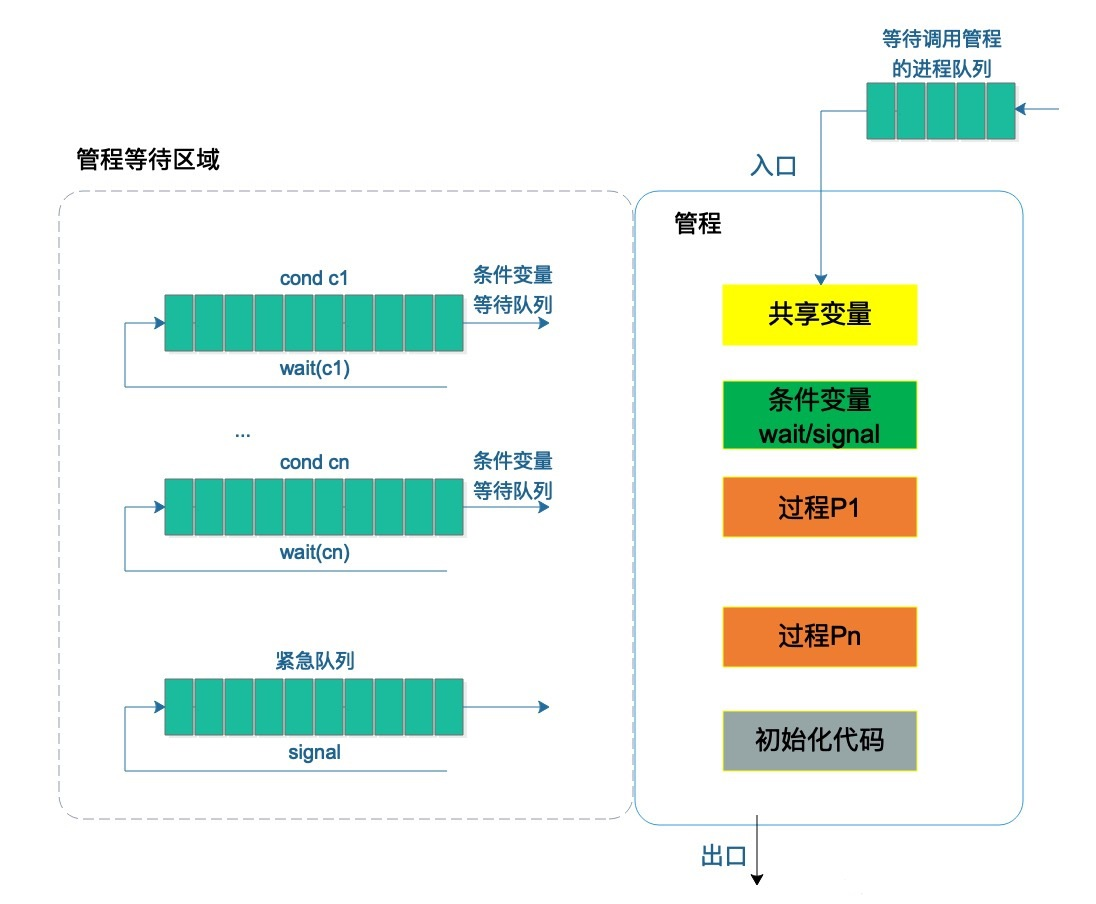

我们先解释下图中右半部分的内容，右上角有一个等待调用的线程队列，管程中每次只能有一个线程在执行任务，所以多个任务需要等待。然后是各个名词的意思，生产-消费需要往队列写入和取出东西，这里的队列就是共享变量，对共享资源进行操作称之为过程（入队和出队两个过程）。而向队列写入和取出是有条件的，写入的时候队列必须是非满的，取出的时候队列必须是非空的，这两个条件被称为条件变量。

然后再来看看左半部分的内容，假设线程T1读取共享变量（即队列），此时发现队列为空（条件变量之一），那么T1此时需要等待，去哪里等呢？去条件变量队列不能为空对应的队列中去等待。此时另一个线程T2向共享变量队列写数据，通过了条件变量队列不能满，那么写完后就会通知线程T1。但因为管程的限制，管程中只能有一个线程在执行，所以T1线程不能立即执行，它会回到右上角的线程等待队列等待（不同的管程模型在这里是有分歧的，比如Hasen模型是立即中断T2线程让队列中下一个线程执行）。

解释完这个图，管程的概念也就呼之欲出了，

> hansen对管程的定义如下：一个管程定义了一个数据结构和能力为并发进程所执行（在该数据结构上）的一组操作，这组操作能同步进程和改变管程中的数据。

本质上，管程是对共享资源以及对共享资源的操作抽象成变量和方法，要操作共享变量仅能通过管程提供的方法（比如上面的入队和出队）间接访问。所以你会发现管程其实和面向对象的理念是十分相近的，在java中，主要提供了低层次了synchronized关键字和wait()，notify()等方法。同时还提供了高层次的ReenTrantLock和Condition来实现管程模型。